# Project: Spam Detection Using Naive Bayes and Natural Language Processing

This project entails an in-depth analysis of a dataset comprising over 5,000 messages, each classified into one of two categories: Ham (legitimate messages) and Spam (unwanted or unsolicited messages).
    
The primary objective is to utilize **Natural Language Processing (NLP)** techniques to build a predictive model to determine whether a given message belongs to the Ham or Spam category. The project will involve data preprocessing, feature extraction, and the application of the **Naive Bayes** machine learning algorithm to train a model. Ultimately, this model will be evaluated and optimized to ensure it can accurately categorize future messages, helping to filter out spam effectively while retaining legitimate communications.

## Imports

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
import sklearn
%matplotlib inline

## Get the Data

For this project I will be using a dataset from the [UCI datasets](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection). The file we are using contains a collection of more than 5 thousand SMS phone messages.

**using rstrip() plus a list comprehension to get a list of all the lines of text messages:**

In [72]:
messages = [line.rstrip() for line in open('smsspamcollection/SMSSpamCollection')]

**printing the first ten messages and number them using enumerate**:

In [73]:
for message_no, message in enumerate(messages[:10]):
    print(message_no, message)
    print('\n')

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


1 ham	Ok lar... Joking wif u oni...


2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


3 ham	U dun say so early hor... U c already then say...


4 ham	Nah I don't think he goes to usf, he lives around here though


5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, Â£1.50 to rcv


6 ham	Even my brother is not like to speak with me. They treat me like aids patent.


7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune


8 spam	WINNER!! As a valued network customer you have been selected to receivea Â£900 prize reward! To claim call 09061701461. Claim cod

Due to the spacing we can tell that this is a TSV ("tab separated values") file, where the first column is a label saying whether the given message is a normal message (commonly known as "ham") or "spam". The second column is the message itself.

Using these labeled ham and spam examples, I will **train a machine learning model to learn to differentiate between ham/spam automatically**. Then, with a trained model, I will be able to **classify arbitrary unlabeled messages** as ham or spam.

using **read_csv** and the **sep** argument to specify the desired column names **"label" and "message"**.

In [74]:
messages = pd.read_csv('smsspamcollection/SMSSpamCollection', sep='\t',
                           names=["label", "message"])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Exploratory Data Analysis

**Checking the head(), info(), and describe() of messages.**

In [75]:
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [76]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [77]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


**making a new column to detect how long the text messages are in order to use this as one of the features for our model**

In [78]:
messages['length'] = messages['message'].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


### Data Visualization


visualising the distribution of the length of the ham and spam columns, using a histogram

array([<Axes: title={'center': 'ham'}>, <Axes: title={'center': 'spam'}>],
      dtype=object)

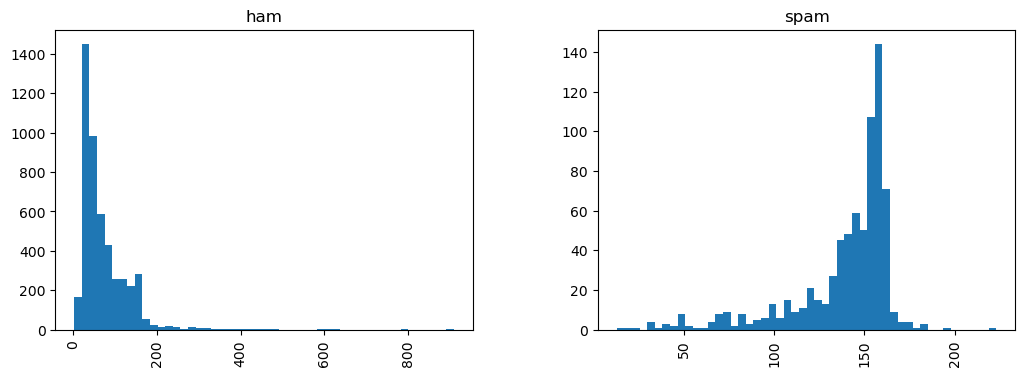

In [79]:
messages.hist(column='length', by='label', bins=50,figsize=(12,4))

From these histograms we can tell that Spam messages tend to have more characters as it has a mode of about **160**, while ham messages haave a mode of about **40**.

## Text Pre-processing

For my classification algorithm to effectively categorize future data into Ham or Spam, it requires numerical input rather than the string-based text currently in my dataset. To achieve this, I will transform the string values into numerical representations using the Bag of Words approach. 

In this section, I will convert the raw messages (sequence of characters) into vectors (sequences of numbers).

As a first step, I will write a function that will split a message into its individual words and return a list. I will also remove very common words, ('the', 'a', etc..) and every punctuation. using the **NLTK** library and Python's built-in **string** library respectively.

After the function is created I can then use **apply()** in pandas to perform the process of all the text in the DataFrame.


In [80]:
from nltk.corpus import stopwords
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all stopwords
    2. Remove all punctuations
    3. Returns a list of the cleaned text
    """
    # Checking characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Joining the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # removing any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

**I will now "tokenize" these messages. Tokenization is the process of converting the normal text strings in to a list of tokens (words that we actually want).**

In [81]:
# Check to make sure its working
messages['message'].head(5).apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

## Vectorization

Currently, I have the messages as lists of tokens (also known as lemmas) and now I need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.

I'll do that in three steps using the bag-of-words model:

1. Count how many times does a word occur in each message (term frequency)

2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)

3. Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

the first step:

Each vector will have as many dimensions as there are unique words in the SMS corpus.  I will first use SciKit Learn's **CountVectorizer**. This model will convert a collection of text documents to a matrix of token counts.

This would be a 2-Dimensional matrix. Where the 1-dimension is the entire vocabulary (1 row per word) and the other dimension are the actual documents, in this case a column per text message. 

For example:

<table border = “1“>
<tr>
<th></th> <th>Message 1</th> <th>Message 2</th> <th>...</th> <th>Message N</th> 
</tr>
<tr>
<td><b>Word 1 Count</b></td><td>0</td><td>1</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word 2 Count</b></td><td>0</td><td>0</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>...</b></td> <td>1</td><td>2</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word N Count</b></td> <td>0</td><td>1</td><td>...</td><td>1</td>
</tr>
</table>


Since there are so many messages, there would be a lot of zero counts for the presence of that word in that document. Because of this, SciKit Learn will output a Sparse Matrix.

In [82]:
from sklearn.feature_extraction.text import CountVectorizer

In [83]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['message'])

#total number of vocab words
print(len(bow_transformer.vocabulary_))

11425


taking one text message and getting its bag-of-words counts as a vector, putting to use the new `bow_transformer`:

In [84]:
message4 = messages['message'][3]
print(message4)

U dun say so early hor... U c already then say...


its vector representation:

In [85]:
bow4 = bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)

  (0, 4068)	2
  (0, 4629)	1
  (0, 5261)	1
  (0, 6204)	1
  (0, 6222)	1
  (0, 7186)	1
  (0, 9554)	2
(1, 11425)


This means that there are seven unique words in message number 4 (after removing common stop words). Two of them appear twice, the rest appaer once.

Now I can use **.transform** on the Bag-of-Words (bow) transformed object and transform the entire DataFrame of messages.

In [86]:
messages_bow = bow_transformer.transform(messages['message'])

After the counting, the term weighting and normalization can be done with **TF-IDF**, using scikit-learn's `TfidfTransformer`.



In [87]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 4068)	0.4083258993338407
  (0, 4629)	0.2661980190608719
  (0, 5261)	0.2972995740586873
  (0, 6204)	0.2995379972369742
  (0, 6222)	0.31872168929491496
  (0, 7186)	0.4389365653379858
  (0, 9554)	0.5385626262927565


To transform the entire bag-of-words corpus into TF-IDF corpus.

In [88]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5572, 11425)


## Training a model

With messages represented as vectors, I can train my spam/ham classifier. I will be using the Naive Bayes classifier algorithm.

In [98]:
from sklearn.naive_bayes import MultinomialNB
spam_detect_model = MultinomialNB().fit(messages_tfidf, messages['label'])
print(spam_detect_model.classes_)

['ham' 'spam']


classifying my single random message and checking how the model does:

In [90]:
print('predicted:', spam_detect_model.predict(tfidf4)[0])
print('expected:', messages.label[3])

predicted: ham
expected: ham


## Part 6: Model Evaluation
Now to want to determine how well my model will do overall on the entire dataset. I will begin by getting all the predictions:

In [91]:
all_predictions = spam_detect_model.predict(messages_tfidf)
print(all_predictions)

['ham' 'ham' 'spam' ... 'ham' 'ham' 'ham']


In [92]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = \
train_test_split(messages['message'], messages['label'], test_size=0.2)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

4457 1115 5572


The test size is 20% of the entire dataset (1115 messages out of total 5572), and the training is the rest (4457 out of 5572).

## Creating a Data Pipeline

I will use SciKit Learn's pipeline capabilities to store a workflow pipeline. This will allow me to set up all the transformations that I will do to the data for future use.

In [93]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

Now I can directly pass message text data and the pipeline will do the pre-processing.

In [94]:
pipeline.fit(msg_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x0000025D4426EAC0>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [95]:
predictions = pipeline.predict(msg_test)

In [96]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(predictions,label_test))

              precision    recall  f1-score   support

         ham       1.00      0.95      0.98       997
        spam       0.72      1.00      0.84       118

    accuracy                           0.96      1115
   macro avg       0.86      0.98      0.91      1115
weighted avg       0.97      0.96      0.96      1115



In [97]:
print(confusion_matrix(predictions, label_test))

[[951  46]
 [  0 118]]


## Conclusion

The model demonstrated a fair performance in classifying messages into Ham and Spam categories, with particularly strong results in **correctly identifying Ham messages**, as evidenced by a **false positive score of 0** and **a precision of 1.00**. However, there is room for improvement in reducing the misclassification of Spam as Ham, as the model yielded a **false negative score of 46**. This indicates that while the model is effective at avoiding the incorrect classification of legitimate messages as Spam, it sometimes fails to identify actual Spam messages, mistakenly classifying them as Ham. Future efforts could focus on refining the model using other machine learning algorithms to reduce these false negatives, ensuring a more accurate and reliable classification process.